Goal
==

We are about to design and train a neural system to perform sentiment analysis on film reviews. More precisely, the network will have to output the probability that the input review expresses a positive opinion (overall).

The system will be a bag-of-words model using GloVe embeddings. It will have to first average the embeddings of the words of the input review, and then send the result through a simple network that should output a probability.

In [ ]:
import torch # PyTorch
import urllib # To download the datasets
import tarfile # To extract the datasets
import os # To read files and inspect directories
import nltk # NLP library
import collections # To define useful data structures
import zipfile
import numpy as np
import torch.nn as nn # To build the Model
import torch.nn.functional as F # For the softmax function
import itertools
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

Loading PyTorch is important.
==

In [ ]:
!pip install matplotlib

Downloading the dataset
==
The dataset we are going to use is the Large Movie Review Dataset (https://ai.stanford.edu/~amaas/data/sentiment/).


In [ ]:
# Downloads the dataset.
tmp = urllib.request.urlretrieve("https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz")
filename = tmp[0]

In [ ]:
filename

'/tmp/tmpk8sxyx8h'

In [ ]:
# Extracts the dataset
tar = tarfile.open(filename)
tar.extractall()
tar.close()

In [ ]:
# Shows which files and directories are present at the root of the file system.
for filename in os.listdir("."):
  print(filename)

.config
aclImdb
sample_data


In [ ]:
dataset_root = "aclImdb"
# Shows which files and directories are present at the root of the dataset directory.
for filename in os.listdir(dataset_root):
  print(filename)

train
imdb.vocab
test
README
imdbEr.txt


In [ ]:
# Shows several reviews.
dirname = os.path.join(dataset_root, "train", "neg") # "aclImdb/{train|test}/{neg|pos}"
for idx, filename in enumerate(os.listdir(dirname)):
  if(idx >= 5): break # Stops after the 5th file.

  print(filename)
  with open(os.path.join(dirname, filename)) as f:
    review = f.read()
    print(review)
  print()

12229_3.txt
This movie started out good, i felt like i was watching an adult version of Seinfeld. Much to quickly i started questioning the situations and actions of the main characters, and found no answers to why they were doing what they were doing. All the acting was superb but only a few scenes had brief moments where they were actually funny. Dan Cortese was amazing. I loved him in this role. His agent should show this movie to casting agents. Watch the first few scenes and then find something better, or else you will find yourself totally lost in this mess. I found this in a bin at a video store. It cost me two dollars and due to the rareness of this movie i feel like it was a good price.

11744_1.txt
After finally viewing this movie in its entirety, I am completely mystified by the adoration it has received by critics and online users alike. Is it the worst Western ever? No, I wouldn't say that. But "the last great American Western", a phrase I saw applied to it more than once?

Preprocessing the dataset
==

In [ ]:
nltk.download('punkt') # Loads a module required for tokenization.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
newline = "<br />" # The reviews sometimes contain this HTLM tag to indicate a line break.
def preprocess(text):
  text = text.replace(newline, " ") # Replaces the newline HTML tag with a space.
  tokens = nltk.word_tokenize(text); # Converts the text to a list of tokens (strings).
  tokens = [token.lower() for token in tokens] # Lowercases all tokens.

  return tokens

# Reads and pre-processes the reviews.
dataset = {"train": [], "test": []}
binary_classes = {"neg": 0, "pos": 1}
for part_name, l in dataset.items():
  for class_name, value in binary_classes.items():
    path = os.path.join(dataset_root, part_name, class_name)
    print("Processing %s..." % path, end='');
    for filename in os.listdir(path):
        with open(os.path.join(path, filename)) as f:
          review_text = f.read()
          review_tokens = preprocess(review_text)

          l.append((review_tokens, value))
    print(" done")

Processing aclImdb/train/neg... done
Processing aclImdb/train/pos... done
Processing aclImdb/test/neg... done
Processing aclImdb/test/pos... done


In [ ]:
# Splits the train set into a proper train set and a development/validation set.
# 'dataset["train"]' happens to be a list composed of a certain number of negative examples followed by the same number of positive examples.
# We are going to use 3/4 of the original train set as our actual train set, and 1/4 as our development set.
# We want to keep balanced train and development sets, i.e. for both, half of the reviews should be positive and half should be negative.
if("dev" in dataset): print("This should only be run once.")
else:
  dev_set_half_size = int((len(dataset["train"]) / 4) / 2) # Half of a quarter of the training set size.
  dataset["dev"] = dataset["train"][:dev_set_half_size] + dataset["train"][-dev_set_half_size:] # Takes some negative examples at the beginning and some positive ones at the end.
  dataset["train"] = dataset["train"][dev_set_half_size:-dev_set_half_size] # Removes the examples used for the development set.

  for (part, data) in dataset.items():
    class_counts = collections.defaultdict(int)
    for (_, p) in data: class_counts[p] += 1
    print(f"{part}: {class_counts}")
  print("Train set split into train/dev.")

train: defaultdict(<class 'int'>, {0: 9375, 1: 9375})
test: defaultdict(<class 'int'>, {0: 12500, 1: 12500})
dev: defaultdict(<class 'int'>, {0: 3125, 1: 3125})
Train set split into train/dev.


Loading the word embeddings
==
We are going to use GloVe embeddings.

All word forms with a frequency below a given threshold are going to be considered unknown forms.

In [ ]:
# Computes the frequency of all word forms in the train set.
word_counts = collections.defaultdict(int)
for tokens, _ in dataset["train"]:
  for token in tokens: word_counts[token] += 1

print(word_counts)

defaultdict(<class 'int'>, {'with': 33000, 'the': 251484, 'exception': 293, 'of': 109248, 'family': 2370, ',': 206913, 'this': 56944, 'new': 3187, 'season': 593, 'is': 83098, 'worse': 1084, 'than': 7380, 'one': 19663, '.': 205306, 'i': 65553, 'ca': 2639, "n't": 25285, 'imagine': 535, 'what': 12094, 'they': 17055, 'are': 22765, 'thinking': 878, 'as': 35262, 'a': 122212, 'fan': 1389, 'horror': 2560, 'can': 9193, 'tolerate': 34, 'lot': 3011, 'gore': 769, 'and': 122695, 'mindless': 113, 'mayhem': 48, 'but': 32042, 'series': 2440, 'gets': 2414, 'each': 1935, 'outing': 50, 'how': 6628, 'disheartening': 4, 'it': 72230, 'must': 2382, 'be': 20244, 'for': 33180, 'actors': 3283, 'crew': 437, 'to': 102031, 'go': 3839, 'work': 3140, 'day': 1895, 'toiling': 2, 'churn': 15, 'out': 12438, 'such': 3828, 'crap': 744, 'story': 8816, '!': 18410, 'that': 55050, 'too': 5846, 'much': 7307, 'ask': 467, '?': 12231, 'character': 5181, 'we': 8110, 'give': 2565, 'damn': 265, 'about': 12982, 'fate': 190, 'anyone':

In [ ]:
# Builds a vocabulary containing only those words present in the train set with a frequency above a given threshold.
count_threshold = 4;
vocabulary = set()
for word, count in word_counts.items():
    if(count > count_threshold): vocabulary.add(word)

print(vocabulary)
print(len(vocabulary))

{'sci-fi', 'instructor', 'guerrero', 'waves', 'objectives', 'kerr', 'bjm', 'owen', 'artificially', 'captors', 'dream-like', 'languid', 'conroy', 'predecessors', 'thinking', 'sink', 'astonishingly', 'corny', 'disgustingly', 'wrecks', 'crown', 'stunk', 'unstoppable', 'mid-80s', 'poking', 'shortage', 'heinlein', 'dedicated', 'ratner', 'cocktail', 'catchphrase', 'same', 'release', 'ongoing', 'marrow', 'colleen', 'triangle', 'walmart', 'behave', 'multiplayer', 'yourself', 'fontaine', 'silverware', 'rear', 'explosion', 'change', 'scoring', 'nihilistic', 'abigail', 'freedoms', 'jerome', 'stupor', 'transferring', 'punched', 'tract', 'linked', 'confines', 'invites', 'fist', 'dealt', 'pop', 'disturbs', 'turkeys', 'scholarship', 'manuscript', 'endless', 'bastards', 'cocktails', 'befriends', 'rays', 'naive', 'crews', "'80", 'joyful', 'disposable', 'parts', 'distortions', 'heretofore', 'offset', 'tripping', 'corresponding', 'virginia', 'cloak', 'ruining', 'sunrise', 'erupts', 'ellis', 'lister', 'di

In [ ]:
# Returns a dictionary {word[String]: id[Integer]} and a list of Numpy arrays.
# `data_path` is the path of the directory containing the GloVe files (if None, 'glove.6B' is used)
# `max_size` is the number of word embeddings read (starting from the most frequent; in the GloVe files, the words are sorted)
# If `vocabulary` is specified (as a set of strings, or a dictionary from strings to integers), the output vocabulary contains the intersection of `vocabulary` and the words with a defined embedding. Otherwise, all words with a defined embedding are used.
def get_glove(dim=50, vocabulary=None, max_size=-1, data_path=None):
  dimensions = set([50, 100, 200, 300]) # Available dimensions for GloVe 6B
  fallback_url = 'http://nlp.stanford.edu/data/glove.6B.zip' # (Remember that in GloVe 6B, words are lowercased.)

  assert (dim in dimensions), (f'Unavailable GloVe 6B dimension: {dim}.')

  if(data_path is None): data_path = 'glove.6B'

  # Checks that the data is here, otherwise downloads it.
  if(not os.path.isdir(data_path)):
    #print('Directory "%s" does not exist. Creation.' % data_path)
    os.makedirs(data_path)

  glove_weights_file_path = os.path.join(data_path, f'glove.6B.{dim}d.txt')

  if(not os.path.isfile(glove_weights_file_path)):
    local_zip_file_path = os.path.join(data_path, os.path.basename(fallback_url))

    if(not os.path.isfile(local_zip_file_path)):
      print(f'Retreiving GloVe embeddings from {fallback_url}.')
      urllib.request.urlretrieve(fallback_url, local_zip_file_path)

    with zipfile.ZipFile(local_zip_file_path, 'r') as z:
      print(f'Extracting GloVe embeddings from {local_zip_file_path}.')
      z.extractall(path=data_path)

  assert os.path.isfile(glove_weights_file_path), (f"GloVe file {glove_weights_file_path} not found.")

  # Reads GloVe data.
  print('Reading GloVe embeddings.')
  new_vocabulary = {} # A dictionary {word[String]: id[Integer]}
  embeddings = [] # The list of embeddings (Numpy arrays)
  with open(glove_weights_file_path, 'r') as f:
    for line in f: # Each line consist of the word followed by a space and all of the coefficients of the vector separated by a space.
      values = line.split()

      # Here, I'm trying to detect where on the line the word ends and where the vector begins. As in some version(s) of GloVe words can contain spaces, this is not entirely trivial.
      vector_part = ' '.join(values[-dim:])
      x = line.find(vector_part)
      word = line[:(x - 1)]

      if((vocabulary is not None) and (not word in vocabulary)): # If a vocabulary was specified and if the word is not it…
        continue # …this word is skipped.

      new_vocabulary[word] = len(new_vocabulary)
      embedding = np.asarray(values[-dim:], dtype=np.float32)
      embeddings.append(embedding)

      if(len(new_vocabulary) == max_size): break
  print('(GloVe embeddings loaded.)')
  print()

  return (new_vocabulary, embeddings)

In [ ]:
%%time
(new_vocabulary, embeddings) = get_glove(dim=50, vocabulary=vocabulary)

Retreiving GloVe embeddings from http://nlp.stanford.edu/data/glove.6B.zip.
Extracting GloVe embeddings from glove.6B/glove.6B.zip.
Reading GloVe embeddings.
(GloVe embeddings loaded.)

CPU times: user 21.7 s, sys: 5.62 s, total: 27.3 s
Wall time: 10min 8s


In [ ]:
print(len(new_vocabulary)) # Shows the size of the vocabulary.
print(new_vocabulary) # Shows each word and its id.

25472
{'the': 0, ',': 1, '.': 2, 'of': 3, 'to': 4, 'and': 5, 'in': 6, 'a': 7, "'s": 8, 'for': 9, '-': 10, 'that': 11, 'on': 12, 'is': 13, 'was': 14, 'said': 15, 'with': 16, 'he': 17, 'as': 18, 'it': 19, 'by': 20, 'at': 21, '(': 22, ')': 23, 'from': 24, 'his': 25, "''": 26, '``': 27, 'an': 28, 'be': 29, 'has': 30, 'are': 31, 'have': 32, 'but': 33, 'were': 34, 'not': 35, 'this': 36, 'who': 37, 'they': 38, 'had': 39, 'i': 40, 'which': 41, 'will': 42, 'their': 43, ':': 44, 'or': 45, 'its': 46, 'one': 47, 'after': 48, 'new': 49, 'been': 50, 'also': 51, 'we': 52, 'would': 53, 'two': 54, 'more': 55, "'": 56, 'first': 57, 'about': 58, 'up': 59, 'when': 60, 'year': 61, 'there': 62, 'all': 63, '--': 64, 'out': 65, 'she': 66, 'other': 67, 'people': 68, "n't": 69, 'her': 70, 'percent': 71, 'than': 72, 'over': 73, 'into': 74, 'last': 75, 'some': 76, 'government': 77, 'time': 78, '$': 79, 'you': 80, 'years': 81, 'if': 82, 'no': 83, 'world': 84, 'can': 85, 'three': 86, 'do': 87, ';': 88, 'president':

Batch generator
==

In [ ]:
# Defines a class of objects that produce batches from the dataset.
class BatchGenerator:
  def __init__(self, dataset, vocabulary):
    self.dataset = dataset
    for part in self.dataset.values(): # Shuffles the dataset so that positive and negative examples are mixed.
      np.random.shuffle(part)

    self.vocabulary = vocabulary # Dictonary {word[String]: id[Integer]}
    self.unknown_word_id = len(vocabulary) # Id for unknown forms
    self.padding_idx = len(vocabulary) + 1 # Not all reviews of a given batch will have the same length. We will "pad" shorter reviews with a special token id so that the batch can be represented by a matrix.

  def length(self, data_type='train'):
    return len(self.dataset[data_type])

  # Returns a random batch.
  # Batches are output as a triples (word_ids, polarity, texts).
  # If `subset` is an integer, only a subset of the corpus is used. This can be useful to debug the system.
  def get_batch(self, batch_size, data_type, subset=None):
    data = self.dataset[data_type] # selects the relevant portion of the dataset.

    max_i = len(data) if(subset is None) else min(subset, len(data))
    instance_ids = np.random.randint(max_i, size=batch_size) # Randomly picks some instance ids.

    return self._ids_to_batch(data, instance_ids)

  def _ids_to_batch(self, data, instance_ids):
    word_ids = [] # Will be a list of lists of word ids (Integer)
    polarity = [] # Will be a list of review polarities (Boolean)
    texts = [] # Will be a list of lists of words (String)
    for instance_id in instance_ids:
      text, p = data[instance_id]

      word_ids.append([self.vocabulary.get(w, self.unknown_word_id) for w in text])
      polarity.append(p)
      texts.append(text)

    # Padding
    self.pad(word_ids)

    word_ids = torch.tensor(word_ids, dtype=torch.long) # Conversion to a tensor
    polarity = torch.tensor(polarity, dtype=torch.bool) # Conversion to a tensor

    return (word_ids, polarity, texts) # We don't really need `texts` but it might be useful to debug the system.

  # Pads a list of lists (i.e. adds fake word ids so that all sequences in the batch have the same length, so that we can use a matrix to represent them).
  # In place
  def pad(self, word_ids):
    max_length = max([len(s) for s in word_ids])
    for s in word_ids: s.extend([self.padding_idx] * (max_length - len(s)))

  # Returns a generator of batches for a full epoch.
  # If `subset` is an integer, only a subset of the corpus is used. This can be useful to debug the system.
  def all_batches(self, batch_size, data_type="train", subset=None):
    data = self.dataset[data_type]

    max_i = len(data) if(subset is None) else min(subset, len(data))

    # Loop that generates all full batches (batches of size 'batch_size').
    i = 0
    while((i + batch_size) <= max_i):
      instance_ids = np.arange(i, (i + batch_size))
      yield self._ids_to_batch(data, instance_ids)
      i += batch_size

    # Possibly generates the last (not full) batch.
    if(i < max_i):
      instance_ids = np.arange(i, max_i)
      yield self._ids_to_batch(data, instance_ids)

  # Turns a list of arbitrary pre-processed texts into a batch.
  # This function will be used to infer the polarity of a unannotated review.
  def turn_into_batch(self, texts):
    word_ids = [[self.vocabulary.get(w, self.unknown_word_id) for w in text] for text in texts]
    self.pad(word_ids)
    return torch.tensor(word_ids, dtype=torch.long)

batch_generator = BatchGenerator(dataset=dataset, vocabulary=new_vocabulary)
print(batch_generator.length('train')) # Prints the number of instance in the train set.

18750


In [ ]:
tmp = batch_generator.get_batch(3, data_type="train")
print(tmp[0]) # Prints the matrix of token ids. This matrix is what will be fed as input to the model (defined below).
print(tmp[1]) # Prints the vector of polarities. This vector will be used to compute the loss when training the model.
print(tmp[2]) # Prints the list of reviews.

tensor([[   36,    13,    28,  ...,  8977,   318,     2],
        [   40,   387,     6,  ..., 25473, 25473, 25473],
        [   36,   989,  3378,  ..., 25473, 25473, 25473]])
tensor([ True, False,  True])
[['this', 'is', 'an', 'extremely', 'dense', ',', 'somber', ',', 'and', 'complicated', 'film', 'that', 'unravels', 'quite', 'slowly', ',', 'revealing', 'excruciating', 'detail', ',', 'like', 'the', 'attention', 'paid', 'in', 'a', 'novel', ',', 'and', 'watching', 'this', 'film', '``', 'is', "''", 'like', 'watching', 'a', 'novel', 'unfold', '.', 'while', 'i', 'did', "n't", 'care', 'for', 'the', 'narrator', ',', 'as', 'i', 'felt', 'he', 'was', 'out', 'of', 'balance', 'with', 'the', 'rest', 'of', 'the', 'performances', ',', 'this', 'film', 'features', 'some', 'of', 'the', 'best', 'ensemble', 'acting', 'i', 'have', 'ever', 'seen', ',', 'and', 'the', 'lead', ',', 'summer', 'phoenix', ',', 'is', 'fabulous', '.', 'her', 'innocence', 'and', 'naivete', 'some', 'might', 'find', 'implausible', ','

In [ ]:
len(list(batch_generator.all_batches(batch_size=3, data_type="train"))) # Number of batches in the training set for batches of size 3

6250

The model
==
This model is expected to accept as input a matrix of token id (in which each line represents a review) and to output a vector (in which each value represents the probability that the corresponding review is positive).


In [ ]:
class SentimentClassifier(torch.nn.Module):
  # embeddings: list of Numpy arrays
  # hidden_sizes: list of the size (Integer) of each hidden layer; there may be 0 or more hidden layers
  # freeze_embeddings: boolean; indicates whether the embeddings should be frozen (i.e., not fine-tuned) during training
  # device: string; indicates on which type of hardware PyTorch computation should be run
  def __init__(self, embeddings, hidden_sizes, freeze_embeddings=True, device='cpu'):
    embeddings = list(embeddings) # Creates a copy of the list of embeddings, so we can add or remove entries without affecting the original list.
    super().__init__() # Calls the constructor of the parent class. Usually, this is necessary when creating a custom module.

    # Here you have to (i) define a vector for unknown forms (the average of actual word embeddings) and a vector for the padding token (full of 0·s) and (ii) define an embedding layer 'self.embeddings' using torch.nn.Embedding.from_pretrained and without forgetting to use the 'freeze' and 'padding_idx' arguments (this last argument is used to keep the padding embedding at 0 even when fine-tuning the other embeddings).
    # The following error (if you get it) indicates that the value provided for 'padding_idx' does not correspond to any embedding in the matrix that you provide (in other words, the matrix is likely to be incomplete): "Padding_idx must be within num_embeddings".
    #################
    # Create a tensor which represent the average of the embeddings
    unknown_form = torch.mean(torch.tensor(embeddings), dim=0) # shape [embedding_size]
    # Create a tensor of 0s of the same shape than the other embeddings
    padding = torch.zeros(unknown_form.size()) # shape [embedding_size]
    # Add to the embedding list the two previously created tensors while converting it in a torch.tensor
    embeddings = torch.cat((torch.tensor(embeddings), torch.stack((unknown_form, padding))), dim=0) # shape [num_embeddings, embedding_size]
    # Create the embedding layer considering the freeze argument as passed in the arguments and the padding index which correspond to the last tensor of the matrix
    self.embeddings = torch.nn.Embedding.from_pretrained(torch.tensor(embeddings), freeze = freeze_embeddings, padding_idx=(len(embeddings)-1)) # shape [num_embeddings, embedding_dim]
    self.padding_idx = len(embeddings)-1
    #################
    self.embeddings = self.embeddings.to(device) # Sends the word embeddings to 'device', which is potentially a GPU.

    # Here you have to define self.main_part, the network that computes a probability for any review given as input (represented as the average of the embeddings of the tokens).
    # The number of hidden layers is determined by 'hidden_sizes, which is a list of integers describing the (output) size of each of them.
    # Use torch.nn.Linear to build linear layers.
    # torch.nn.Sequential takes one argument per module and not a list of modules as argument, but if 'modules' is a list of modules, 'torch.nn.Sequential(*modules)' (with the star notation) works.
    #################
    modules = [] #list of modules that will be used to build the torch.nn.Sequential
    input_size = unknown_form.size()[0] #the input of the model is a given review and its corresponds to the average of its embeddings so it must be of their size

    for hidden_output_size in hidden_sizes :
      hidden_layer = [nn.Linear(input_size,hidden_output_size),nn.ReLU()] #a hidden layer corresponds to a linear layer + an activation function
      modules.extend(hidden_layer)
      input_size = hidden_output_size #we keep in memory the size of the output to feed the following input size

    modules.extend([nn.Linear(input_size,1),torch.nn.Sigmoid()]) #the final layer with the sigmoid function to have a probability

    self.main_part = torch.nn.Sequential(*modules)
    #################
    self.main_part = self.main_part.to(device) # Sends the network to 'device', which is potentially a GPU.

    self.device = device

  # 'batch' is 2D tensor (i.e. a matrix) of word ids (Integer).
  def forward(self, batch):
    # Here you have to (i) turn 'batch' into a matrix of embeddings (i.e. a tensor of rank 3),
    #(ii) average all embeddings for a given review while being careful not to take into account padding vectors,
    #(iii) send these bag-of-words representations to the network.
    # Return a tensor of shape (batch size) instead of (batch size, 1).
    # Once you think the function works, check that the presence of padding ids does NOT impact the result in any way (i.e. the same probability should be computed for a given review independently of the number of padding ids).
    #################
    # Turn batch into a matrix of embeddings
    embedded_batch = self.embeddings(batch) # shape [batch_size, max_sequence_length, embedding_dim]

    # Average embeddings while ignoring padding vectors
    mask = (batch != (self.padding_idx)).unsqueeze(-1).float()
    sum_embeddings = torch.sum(embedded_batch * mask, dim=1) # shape [batch_size, embedding_dim]
    avg_embeddings = sum_embeddings / torch.sum(mask, dim=1) # shape [batch_size, embedding_dim]

    # Send bag-of-words representations to the network
    output = self.main_part(avg_embeddings).squeeze()  # Remove the extra dimension shape [batch_size]
    return output
    #################

In [ ]:
SentimentClassifier(embeddings, hidden_sizes=[], freeze_embeddings=True)

<ipython-input-23-2d851e4b6106>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  unknown_form = torch.mean(torch.tensor(embeddings), dim=0) # shape [embedding_size]
<ipython-input-23-2d851e4b6106>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embeddings = torch.nn.Embedding.from_pretrained(torch.tensor(embeddings), freeze = freeze_embeddings, padding_idx=(len(embeddings)-1)) # shape [num_embeddings, embedding_dim]


SentimentClassifier(
  (embeddings): Embedding(25474, 50, padding_idx=25473)
  (main_part): Sequential(
    (0): Linear(in_features=50, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [ ]:
model = SentimentClassifier(embeddings, hidden_sizes=[100], freeze_embeddings=True)
batch = batch_generator.get_batch(3, data_type="train")
print(model(batch[0])) # This output (its shape) should be checked.
print("Shape: ", model(batch[0]).shape)

tensor([0.5070, 0.5070, 0.5039], grad_fn=<SqueezeBackward0>)
Shape:  torch.Size([3])


<ipython-input-23-2d851e4b6106>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embeddings = torch.nn.Embedding.from_pretrained(torch.tensor(embeddings), freeze = freeze_embeddings, padding_idx=(len(embeddings)-1)) # shape [num_embeddings, embedding_dim]


In [ ]:
# Function that computes the accuracy of the model on a given part of the dataset.
evaluation_batch_size = 256
def evaluation(model, data_type, subset=None):
  nb_correct = 0
  total = 0
  for batch in batch_generator.all_batches(evaluation_batch_size, data_type=data_type, subset=subset):
    prob = model(batch[0].to(model.device)) # Forward pass
    answer = (prob > 0.5) # Shape: (evaluation_batch_size, 1)
    nb_correct += (answer == batch[1].to(model.device)).sum().item()
    total += batch[0].shape[0]

  accuracy = (nb_correct / total)
  return accuracy

Training
==
Once everything works, try to find better hyperparameters.
The goal is to maximise the accuracy on the development set.

## First training

In [ ]:
# Intitial parameters
params_init = {
    'batch_size': 64,
    'freeze_embeddings': False,
    'learning_rate': 0.004,
    'hidden_sizes': [20,10],
    'l2_reg': 0.0001,
    'nb_epochs': 20
}
# Testing parameters
params_test = {
    'batch_size': 64,
    'freeze_embeddings': False,
    'learning_rate': 0.004,
    'hidden_sizes': [200, 100],
    'l2_reg': 0.0001,
    'nb_epochs': 20
}
model = SentimentClassifier(embeddings, hidden_sizes=params_test["hidden_sizes"], freeze_embeddings=params_test["freeze_embeddings"], device='cuda')

# Tests the model on a couple of instance before training.
model.eval() # Tells PyTorch we are in evaluation/inference mode (can be useful if dropout is used, for instance).
print(model(batch_generator.turn_into_batch([preprocess(text) for text in ["This movie was terrible!!", "Pure gold!"]]).to(model.device)))

# Training procedure
learning_rate = params_test["learning_rate"]
l2_reg = params_test["l2_reg"]
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.99, weight_decay=l2_reg) # Once the backward propagation has been done, just call the 'step' method (with no argument) of this object to update the parameters.
batch_size = params_test["batch_size"]
subset = None # Use an integer to train on a smaller portion of the training set, otherwise use None.
epoch_size = batch_generator.length("train") if(subset is None) else subset # In number of instances

nb_epoch = params_test["nb_epochs"]
epoch_id = 0 # Id of the current epoch
instances_processed = 0 # Number of instances trained on in the current epoch
epoch_loss = [] # Will contain the loss for each batch of the current epoch

average_losses = []
train_accuracies = []
dev_accuracies = []

while(epoch_id < nb_epoch):
  model.train() # Tells PyTorch that we are in training mode

  model.zero_grad() # Makes sure the gradient is reinitialised to zero.

  batch = batch_generator.get_batch(batch_size, data_type="train", subset=subset) # The batch to train on at this iteration.

  # You have to (i) compute the prediction of the model (you might want to use ".to(model.device)" on the input of the model), (ii) compute the loss (use an average over the batch), (iii) call "backward" on the loss and (iv) store the loss in "epoch_loss".
  ###################

  (words_ids,polarities,texts) = batch

  # (i) Compute predictions of the model
  predictions = model(words_ids.to(model.device)).to(model.device) #shape [batch_size]

  # (ii) Compute the loss (use an average over the batch)
  labels_gold = polarities.float().to(model.device) #shape [batch_size]
  loss = torch.nn.BCELoss(reduction='mean') (predictions, labels_gold.type(torch.float))

  # (iii) Backpropagation
  loss.backward()

   #(iv) store the loss in "epoch_loss"
  epoch_loss.append(loss.item())
  ###################

  optimizer.step() # Updates the parameters.

  instances_processed += batch_size
  if(instances_processed > epoch_size): # If this iteration corresponds to the end of an epoch.
    print(f"-- END OF EPOCH {epoch_id}.")
    print(f"Average loss: {sum(epoch_loss) / len(epoch_loss)}.")
    average_losses.append(sum(epoch_loss) / len(epoch_loss))

    # Evaluation
    model.eval() # Tells PyTorch we are in evaluation/inference mode (can be useful if dropout is used, for instance).
    with torch.no_grad(): # Deactivates Autograd (it is computationaly expensive and we don't need it here).
      accuracy = evaluation(model, "train")
      print(f"Accuracy on the train set: {accuracy}.")
      train_accuracies.append(accuracy)

      accuracy = evaluation(model, "dev")
      print(f"Accuracy on the dev set: {accuracy}.")
      dev_accuracies.append(accuracy)

    epoch_id += 1
    instances_processed -= epoch_size
    epoch_loss = []

<ipython-input-23-2d851e4b6106>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embeddings = torch.nn.Embedding.from_pretrained(torch.tensor(embeddings), freeze = freeze_embeddings, padding_idx=(len(embeddings)-1)) # shape [num_embeddings, embedding_dim]


tensor([0.5048, 0.5075], device='cuda:0', grad_fn=<SqueezeBackward0>)
-- END OF EPOCH 0.
Average loss: 0.6831842728035442.
Accuracy on the train set: 0.6520533333333334.
Accuracy on the dev set: 0.64624.
-- END OF EPOCH 1.
Average loss: 0.6135077894547694.
Accuracy on the train set: 0.7236266666666666.
Accuracy on the dev set: 0.70784.
-- END OF EPOCH 2.
Average loss: 0.5759101010630155.
Accuracy on the train set: 0.7608533333333334.
Accuracy on the dev set: 0.7504.
-- END OF EPOCH 3.
Average loss: 0.48201040898166825.
Accuracy on the train set: 0.7829866666666667.
Accuracy on the dev set: 0.7688.
-- END OF EPOCH 4.
Average loss: 0.526545230744235.
Accuracy on the train set: 0.75792.
Accuracy on the dev set: 0.7448.
-- END OF EPOCH 5.
Average loss: 0.4624880970338099.
Accuracy on the train set: 0.8058133333333334.
Accuracy on the dev set: 0.7912.
-- END OF EPOCH 6.
Average loss: 0.4379700109006602.
Accuracy on the train set: 0.7891733333333333.
Accuracy on the dev set: 0.76928.
-- END 

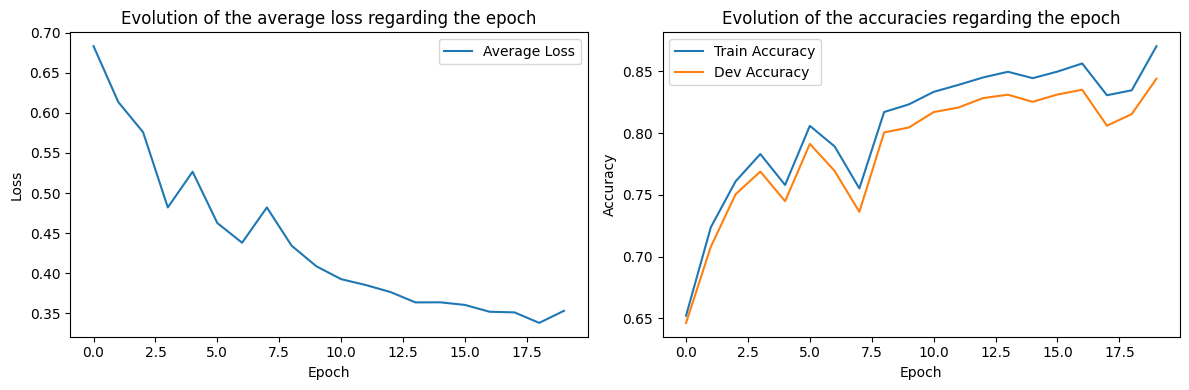

In [ ]:
#Visualizing the results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(average_losses, label='Average Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evolution of the average loss regarding the epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(dev_accuracies, label='Dev Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Evolution of the accuracies regarding the epoch')
plt.legend()

plt.tight_layout()

plt.show()

## Hyperparameter tuning

In [ ]:
#Setting a variety of values to test during the gridSearch
param_grid = {
    'batch_size': [32,64,128],
    'embedding_dim': [50,100],
    'freeze_embeddings': [True,False],
    'learning_rate': [0.002,0.004,0.008],
    'hidden_sizes': [[20,10],[200,100],[200]],
    'patience': [5, 20,10],
    'l2_reg': [0.0001,0.0002,0.001],
    'nb_epochs' : [20,50]
}

# Initialize lists for results
results = {
    'hyperparams': [],
    'val accuracy': [],
    'val loss': []
}

# Grid search loop
for hyperparams in itertools.product(*param_grid.values()):
  batch_size, embedding_dim, freeze_embeddings, learning_rate, hidden_sizes, patience, l2_reg, nb_epochs = hyperparams

  print(f"\nGrid search iteration with parameters:")
  print(f"Num Epoch : {nb_epochs}, L2 regularizer : {l2_reg}")
  print(f"Batch Size: {batch_size}, Embedding Dim: {embedding_dim}, Freeze Embeddings: {freeze_embeddings}")
  print(f"Learning Rate: {learning_rate}, Hidden sizes: {hidden_sizes}, Patience: {patience}")

  # Model initialization
  model = SentimentClassifier(
      embeddings,
      hidden_sizes=hidden_sizes,
      freeze_embeddings=freeze_embeddings,
      device='cuda'
  )

  # Training procedure
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.99, weight_decay=l2_reg) # Once the backward propagation has been done, just call the 'step' method (with no argument) of this object to update the parameters.
  subset = None # Use an integer to train on a smaller portion of the training set, otherwise use None.
  epoch_size = batch_generator.length("train") if(subset is None) else subset # In number of instances

  epoch_id = 0 # Id of the current epoch
  instances_processed = 0 # Number of instances trained on in the current epoch
  epoch_loss = [] # Will contain the loss for each batch of the current epoch
  val_epoch_loss = []

  average_val_losses = [] #list of average validation loss on the whole dev set that will be completed after each epoch
  average_epoch_losses = [] #list of tranning loss on a batch that will be completed after each epoch
  train_accuracies = [] #list of trainning accuracies that will be completed after each epoch
  dev_accuracies = [] #list of validation accuracies that will be completed after each epoch

  early_stopping_counter = 0 #to stop the trainning according to the value of the patience
  best_val_loss = float('inf')

  while(epoch_id < nb_epochs):
    model.train()
    model.zero_grad()
    batch = batch_generator.get_batch(batch_size, data_type="train", subset=subset)
    (words_ids,polarities,texts) = batch
    predictions = model(words_ids.to(model.device)).to(model.device)
    labels_gold = polarities.float().to(model.device)
    loss = torch.nn.BCELoss(reduction='mean') (predictions, labels_gold.type(torch.float))
    loss.backward()
    epoch_loss.append(loss.item())
    optimizer.step()

    # Validation
    val_batch = batch_generator.get_batch(batch_size, data_type="dev", subset=subset)
    # Unpack the validation batch into words IDs, polarities, and texts
    (val_words_ids, val_polarities, val_texts) = val_batch
    # Compute predictions on the validation set using the model
    val_predictions = model(val_words_ids.to(model.device)).to(model.device)
    # Convert validation labels to the appropriate data type and move to the same device as predictions
    val_labels_gold = val_polarities.float().to(model.device)
    # Compute the validation loss using binary cross-entropy loss
    val_loss = torch.nn.BCELoss(reduction='mean')(val_predictions, val_labels_gold.type(torch.float))
    # Append the validation loss to the list of validation losses for this epoch
    val_epoch_loss.append(val_loss.item())

    instances_processed += batch_size
    if(instances_processed > epoch_size): # If this iteration corresponds to the end of an epoch.
      print(f"\n-- END OF EPOCH {epoch_id+1}.")
      average_loss = sum(epoch_loss) / len(epoch_loss)
      print(f"Average loss: {average_loss}.")
      average_epoch_losses.append(average_loss)

      val_average_loss = sum(val_epoch_loss) / len(val_epoch_loss)
      print(f"Average validation loss: {val_average_loss}.")
      average_val_losses.append(val_average_loss)

      # Check for early stopping
      if val_average_loss < best_val_loss:
          # If the validation loss improved, update the best validation loss and reset the counter
          best_val_loss = val_average_loss
          early_stopping_counter = 0
      else:
          # If the validation loss did not improve, increment the early stopping counter
          early_stopping_counter += 1

      if early_stopping_counter >= patience:
          # If early stopping criterion is met, print a message and break out of training loop
          print(f"Early stopping after {early_stopping_counter} epochs without improvement.")
          break

      # Evaluation
      model.eval() # Set the model in evaluation mode
      # Calculate accuracy on the training set
      with torch.no_grad():
        accuracy = evaluation(model, "train")
        print(f"Accuracy on the train set: {accuracy}.")
        train_accuracies.append(accuracy)

        dev_accuracy = evaluation(model, "dev")
        print(f"Accuracy on the dev set: {dev_accuracy}.")
        dev_accuracies.append(dev_accuracy)

      # Update epoch and instances_processed counters, and reset loss lists
      epoch_id += 1
      instances_processed -= epoch_size
      epoch_loss = []
      val_epoch_loss = []

  #Keeps the result for the plot.
  results['hyperparams'].append(hyperparams)

  #Here, keeps the last value of dev_accuracy and average_val_loss because they correspond to the trained results
  results['val accuracy'].append(dev_accuracy)
  results['val loss'].append(val_average_loss)


Grid search iteration with parameters:
Num Epoch : 20, L2 regularizer : 0.0001
Batch Size: 32, Embedding Dim: 50, Freeze Embeddings: True
Learning Rate: 0.002, Hidden sizes: [20, 10], Patience: 5


<ipython-input-23-2d851e4b6106>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.embeddings = torch.nn.Embedding.from_pretrained(torch.tensor(embeddings), freeze = freeze_embeddings, padding_idx=(len(embeddings)-1)) # shape [num_embeddings, embedding_dim]



-- END OF EPOCH 1.
Average loss: 0.6950878765395884.
Average validation loss: 0.6949448640436036.
Accuracy on the train set: 0.5.
Accuracy on the dev set: 0.5.

-- END OF EPOCH 2.
Average loss: 0.6879864066534075.
Average validation loss: 0.6874770670620655.
Accuracy on the train set: 0.6301866666666667.
Accuracy on the dev set: 0.61248.

-- END OF EPOCH 3.
Average loss: 0.6114512804526925.
Average validation loss: 0.6152204846257643.
Accuracy on the train set: 0.7354666666666667.
Accuracy on the dev set: 0.728.

-- END OF EPOCH 4.
Average loss: 0.6050090011679679.
Average validation loss: 0.6130404558808323.
Accuracy on the train set: 0.7064.
Accuracy on the dev set: 0.69264.

-- END OF EPOCH 5.
Average loss: 0.5962383670815022.
Average validation loss: 0.5998830563379229.
Accuracy on the train set: 0.7242133333333334.
Accuracy on the dev set: 0.71824.

-- END OF EPOCH 6.
Average loss: 0.554502758200665.
Average validation loss: 0.5707981714616457.
Accuracy on the train set: 0.716693

KeyboardInterrupt: ignored

**Remarks**

According to how the datasets were build, we know that we have a baseline accuracy (=most frequent polarity) of exactly 0.5 because the data were stricly divided on their half. Then, an accuracy of 0.5 represents our starting point and is to be increased. Our first trainning displayed an accuracy of 0.8 on the dev set and we will try several combinations of hyperparameters to try to improve this result.


Regarding the printed results, we can notice that the model does not always converge. Indeed, one of our test is to try different numbers of epochs and when testing a number of epochs such as nb_epochs=50 at first, the trainning is stopped by our early stopping procedure (at epoch 12 with a patience=5) even though the preceding trainning (nb_epochs=20) displayed great improvements in the results until the last epoch.


This divergence phenomenon is not solved by the increasing of the l2 regularizer (mutliplied by 2 and 10) nor the increasing of the patience (from 5 to 20). It's stagnates around 0.73.

To increase the number of neurons and the hidden layers did not help as well as we could observe an early stop (at epoch 10 with a patience=5) as soon as the hidden_sizes went from [20,10] to [200,100].


In [ ]:
## Analysis and visualization
# Flatten the multi-dimensional arrays and convert to NumPy arrays
results['hyperparams'] = np.array([np.ravel(hyperparams) for hyperparams in results['hyperparams']])
results['val accuracy'] = np.array(results['val accuracy'])
results['val loss'] = np.array([loss for loss in results['val loss']])

# Convert any remaining tensors to NumPy arrays on the CPU
results['hyperparams'] = [hyperparam.cpu().numpy() if isinstance(hyperparam, torch.Tensor) else hyperparam for hyperparam in results['hyperparams']]

# Create a DataFrame from the modified results dictionary
results_df = pd.DataFrame(results)

# Sort results by accuracy in descending order
results_df = results_df.sort_values(by='val accuracy', ascending=False)

# Print the top-performing configurations
print("Top-performing configurations:")
print("reminder hyperparams : [batch_size, embedding_dim, freeze_embeddings, learning_rate, hidden_sizes, num_hidden_layers, patience]")
print(results_df.head())

# Select the best configuration based on validation results
best_index = np.argmax(results['val accuracy'])
best_params = results['hyperparams'][best_index]

# Test the final model on the test dataset
# Extract individual hyperparameters from the best_params tuple
batch_size, embedding_dim, freeze_embeddings, learning_rate, hidden_sizes, num_hidden_layers, patience, l2_reg, nb_epochs = best_params

# Initialize a new model with the best hyperparameters
best_model = SentimentClassifier(
    embeddings,
    hidden_sizes=hidden_sizes,
    freeze_embeddings=freeze_embeddings,
    device='cuda'
)

# Load and preprocess the test dataset
test_batch_size = 64
test_batch_generator = BatchGenerator(dataset=dataset, vocabulary=new_vocabulary)
test_data_size = test_batch_generator.length('test')
test_batches = test_data_size // test_batch_size

# Evaluate the model on the test dataset
test_accuracy = evaluation(best_model, data_type="test")

# Print the test accuracy
print(f"Test Accuracy: {test_accuracy:.4f}")

Top-performing configurations:
reminder hyperparams : [batch_size, embedding_dim, freeze_embeddings, learning_rate, hidden_sizes, num_hidden_layers, patience]
                                      hyperparams  val accuracy  val loss
1  [32, 50, True, 0.002, [20, 10], 5, 0.0001, 50]       0.75712  0.517963
0  [32, 50, True, 0.002, [20, 10], 5, 0.0001, 20]       0.74912  0.528458
2  [32, 50, True, 0.002, [20, 10], 5, 0.0002, 20]       0.74864  0.522566


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:1859: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


ValueError: ignored

In [ ]:
#Extracts the specified parameter of the hyperparams list stored in the DataFrame to create plots.
#Allows to returns a Serie of the specified parameter when applied to the column 'hyperparams'.
#reminder hyperparams : batch_size, embedding_dim, freeze_embeddings, learning_rate, hidden_sizes, patience, l2_reg, nb_epochs
def extract_hyperparams(hyperparams, param) :
  if param == "batch_size" : return hyperparams[0]
  elif param == "embedding_dim" : return hyperparams[1]
  elif param == "freeze_embbedings" : return hyperparams[2]
  elif param == "learning_rate" : return hyperparams[3]
  elif param == "hidden_sizes" : return hyperparams[4]
  elif param == "patience" : return hyperparams[5]
  elif param == "l2_reg" : return hyperparams[6]
  elif param == "nb_epochs" : return hyperparams[7]

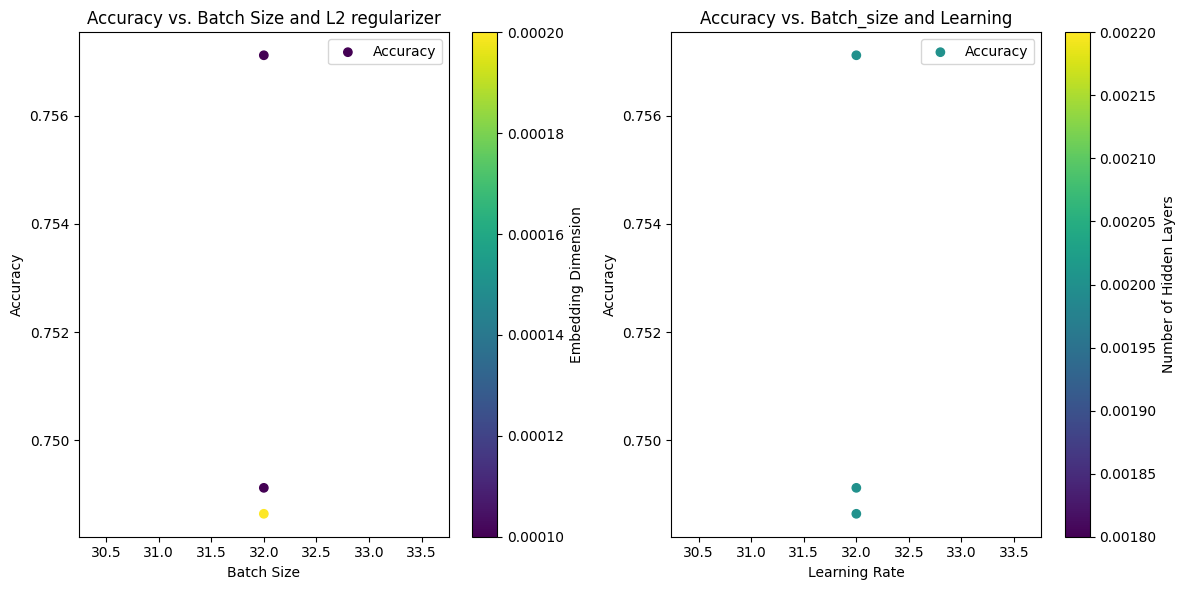

In [ ]:
# Visualize results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(results_df['hyperparams'].apply(lambda x : extract_hyperparams(x,"batch_size")), results_df['val accuracy'], c=results_df['hyperparams'].apply(lambda x : extract_hyperparams(x,"l2_reg")), cmap='viridis', label='Accuracy')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Batch Size and L2 regularizer')
plt.colorbar(label='Embedding Dimension')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(results_df['hyperparams'].apply(lambda x : extract_hyperparams(x,"batch_size")), results_df['val accuracy'], c=results_df['hyperparams'].apply(lambda x : extract_hyperparams(x,"learning_rate")), cmap='viridis', label='Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Batch_size and Learning')
plt.colorbar(label='Number of Hidden Layers')
plt.legend()

plt.tight_layout()
plt.show()